- Name: `dissipation-theory--Study-28.ipynb`
- Author: John A. Marohn
- Date: 2024-10-13
- Continued from: `dissipation-theory--Study-26.ipynb`
- Continued to: ---
- Summary: Redo `Study 26` using numba/jit-accelerated functions coded in `dissipationtheory.dissipation3`.  The numba/jit functions run below are 100 to 200 times faster than their pure-Python counterparts run in `Study 26`, enabling us to plot here a more detailed BLDS spectrum and explore friction and the zero-frequency limit of the BLDS spectrum as a function of many more conductivity points.

# Preliminaries

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
THIS = 'dissipation-theory--Study-28--'
fig = {}

In [4]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation3 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation3 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation3 import theta1norm, gamma_perpendicular
from dissipationtheory.dissipation3 import theta1norm_jit, gamma_perpendicular_jit
from dissipationtheory.dissipation3 import blds_perpendicular, blds_perpendicular_jit
from dissipationtheory.dissipation3 import BLDSlimits, BLDSapprox

# Sample object

Set up pure Python objects.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

In [6]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(500, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

Magically, set up the jit sample model from the pure Python sample model, as described in `Study 27`.

In [7]:
sample1_jit = SampleModel1Jit(**sample1.args())

# Example friction calculation

Spot-check the new friction-calculation code by comparing a numba/jit result to a pure-Python result.

First, the numba/jit result.

In [8]:
%%time
ans1a = gamma_perpendicular_jit(theta1norm_jit, sample1_jit)
ans1a 

CPU times: user 9.72 ms, sys: 438 µs, total: 10.2 ms
Wall time: 10.4 ms


Magnitude,[3.935960284420399 2.0717048238564075 0.5163580638291033]
Units,piconewton second/meter


Now the pure Python result.

In [9]:
%%time
ans1b = gamma_perpendicular(theta1norm, sample1)
ans1b 

CPU times: user 2.07 s, sys: 28.3 ms, total: 2.09 s
Wall time: 2.21 s


Magnitude,[3.935960284420396 2.071704823856406 0.5163580638291028]
Units,piconewton second/meter


By inspection we get the same result for the three terms' contribution to the friction.  Success!

The numba/jit calculation is 100 to 200 times faster.  

# Example BLDS calculation

In [10]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 2, 2), 'Hz')

In [11]:
%%time
ans2a = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m)
ans2a 

CPU times: user 22.8 ms, sys: 1.11 ms, total: 23.9 ms
Wall time: 26 ms


Magnitude,[[-6.2018844785453355 -1.9086751902497248 -2.8074726923702045] [-6.201884131240044 -1.908668735156521 -2.8072058803783237]]
Units,hertz


In [12]:
%%time
ans2b = blds_perpendicular(theta1norm, sample1, omega_m)
ans2b 

CPU times: user 5.52 s, sys: 65.7 ms, total: 5.59 s
Wall time: 5.96 s


Magnitude,[[-6.201884478545333 -1.9086751902497232 -2.807472692370203] [-6.201884131240042 -1.9086687351565201 -2.807205880378323]]
Units,hertz


By inspection we get the same result for the two terms' contribution to the BDLS frequency shift at the .  Success!

The numba/jit calculation is 150 to 200 times faster.  

# Create list of modulation frequencies and charge densities

Set up arrays of modulation frequency $\omega_{\mathrm{m}}$ and conductivity $\sigma$.

In [13]:
N_omega = 100
N_sigma = 50

In [14]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [15]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  

In [16]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 

As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [17]:
rho = (sigma / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [18]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.

In [19]:
%%time

# remember
sigma0 = sample1_jit.sigma
rho0 =  sample1_jit.rho

# set
for rho_, sigma_ in zip(rho, sigma):

    sample1_jit.rho = rho_.to('1/m^3').magnitude
    sample1_jit.sigma = sigma_.to('S/m').magnitude

    gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
    f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
    
    data['01'][str(sigma_.to('S/m').magnitude)] = {
        'omega_m': omega_m,
        'f_BLDS': f_BLDS, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
        'd': ureg.Quantity(sample1_jit.cantilever.d, 'm'),
        'rho': ureg.Quantity(sample1_jit.rho, '1/m^3'),
        'LD': ureg.Quantity(sample1_jit.LD, 'm'),
        'omega_c': ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz'),
        'omega_0': (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')}

# reset
sample1_jit.rho = rho0
sample1_jit.sigma = sigma0

CPU times: user 12.1 s, sys: 161 ms, total: 12.2 s
Wall time: 12.9 s


From `Study 25`, a helper function to plot the BLDS spectra.  Make sure to add up the three terms to get the total BLDS frequency shift.

In [20]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 3rd BLDS spectrum.

In [21]:
data['01-short'] = {}
for key in list(data['01'].keys())[::3]:
    data['01-short'][key] = data['01'][key]

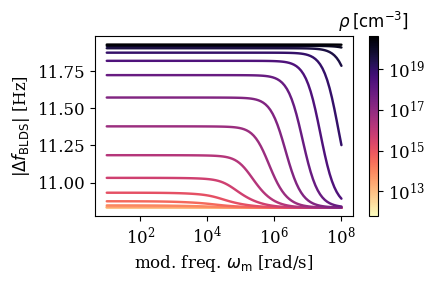

In [22]:
fig['01'] = plotBLDS(data['01-short'])

Tweak the `Study 26` code.

In [23]:
def plotme(data, sample):

    # Loop over the data and gather up the charge density, Debye length, cantilever height,
    # friction and BLDS frequency shift at the lowest modulation frequency (approximating
    # the zero-frequency limit)
    
    rho = np.zeros(len(data))
    LD = np.zeros(len(data))
    d = np.zeros(len(data))
    gamma = np.zeros((len(data),3))
    blds0 = np.zeros((len(data),3))
    omega_0 = np.zeros(len(data))
    omega_c = np.zeros(len(data))
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        LD[index] = data[key]['LD'].to('m').magnitude
        d[index] = data[key]['d'].to('m').magnitude
        gamma[index] = data[key]['gamma'].to('pN s/m').magnitude
        blds0[index] = np.abs(data[key]['f_BLDS'][0,:].to('Hz').magnitude)
        omega_0[index] = data[key]['omega_0'].to('Hz').magnitude
        omega_c[index] = data[key]['omega_c'].to('Hz').magnitude
    
    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (d/LD)**2
    rho0L = (rho/xL)[0]

    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = omega_0/(sample.epsilon_s.real.magnitude * omega_c)
    rho0R = (rho/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))

    BLDS_low, BLDS_high = BLDSlimits(sample, xL)
    xL_sub, BLDS_sub = BLDSapprox(sample, xL)

    with plt.style.context('seaborn-v0_8'):
        ax[0].semilogx(xL, BLDS_low.to('Hz').magnitude, 'k--')
        ax[0].semilogx(xL, BLDS_high.to('Hz').magnitude, 'k-.')
        ax[0].semilogx(xL_sub, BLDS_sub.to('Hz').magnitude,'k-', label='approx')
        ax[0].semilogx(xL, blds0, '-', label=['$K_2$','$K_1$','$K_0$'])
        ax[1].semilogx(xR, gamma, '-', label=['$K_2$','$K_1$','$K_0$'])
        
    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[0].set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax[0].legend(fontsize=9)
    ax[0].grid()
    ax[1].grid()
    
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[1].legend(fontsize=9)
    
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

Pass sample parameters via `sample1`, where the parameters have units, not via `sample1_jit`, there the parameters don't have units.

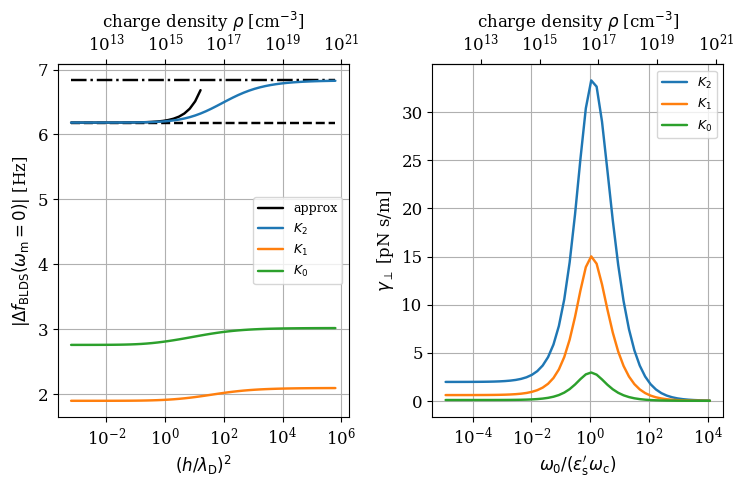

In [24]:
fig['02'] = plotme(data['01'], sample1)

# Save all figures

In [25]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')